<a href="https://colab.research.google.com/github/alfanugraha/mlzoomcamp-homework/blob/master/06_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import  roc_auc_score, auc

In [19]:
def rmse(y, y_pred):
    err = y - y_pred
    se = err ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


### Handling missing values

In [4]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [5]:
df_car = df.fillna(0)
df_car.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

### Partitioning the data

In [6]:
df_full_train, df_test = train_test_split(df_car, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"]
del df_test["fuel_efficiency_mpg"]

### One-hot encoding

In [7]:
train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Q1. Decision tree regressor 

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



`vehicle_weight` is used for splitting the data

## Q2. Random forest regressor

In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
y_pred = rf.predict(X_val)
print('RMSE on the validation dataset = %.5f' % rmse(y_val, y_pred))

RMSE on the validation dataset = 0.45998


## Q3. Number of estimators

In [24]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse_val = rmse(y_val, y_pred)
    print('n_estimators=%d RMSE=%.3f' % (n, rmse_val))

    scores.append((n, rmse_val))

n_estimators=10 RMSE=0.460
n_estimators=20 RMSE=0.454
n_estimators=30 RMSE=0.451
n_estimators=40 RMSE=0.448
n_estimators=50 RMSE=0.446
n_estimators=60 RMSE=0.445
n_estimators=70 RMSE=0.445
n_estimators=80 RMSE=0.445
n_estimators=90 RMSE=0.445
n_estimators=100 RMSE=0.444
n_estimators=110 RMSE=0.443
n_estimators=120 RMSE=0.444
n_estimators=130 RMSE=0.443
n_estimators=140 RMSE=0.443
n_estimators=150 RMSE=0.443
n_estimators=160 RMSE=0.443
n_estimators=170 RMSE=0.443
n_estimators=180 RMSE=0.442
n_estimators=190 RMSE=0.443
n_estimators=200 RMSE=0.443


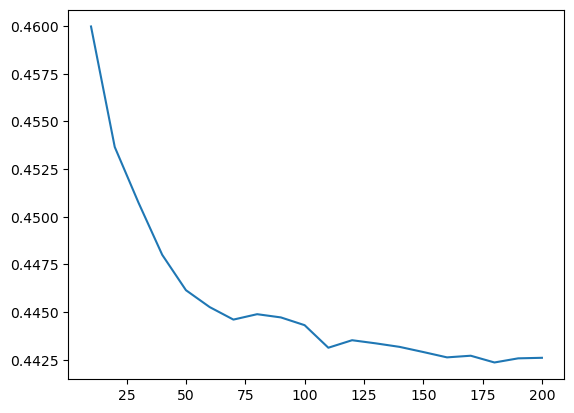

In [25]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

RMSE is stop improving significantly after `n_estimators = 180` ~ 200

## Q4. Best max depth

In [29]:
scores = []
mean_rmse = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse_val = rmse(y_val, y_pred)
        # print('max_depth=%d n_estimators=%d RMSE=%.3f' % (d, n, rmse_val))

        scores.append((d, n, rmse_val))
    
    # Calculate mean RMSE for this depth
    rmse_values = [s[2] for s in scores if s[0] == d]
    mean_rmse.append((d, np.mean(rmse_values)))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])


In [30]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.451895
1,10,20,0.448719
2,10,30,0.446225
3,10,40,0.443877
4,10,50,0.442682
...,...,...,...
75,25,160,0.442689
76,25,170,0.442767
77,25,180,0.442415
78,25,190,0.442618


In [28]:
mean_rmse

[(10, 0.44232130237115186),
 (15, 0.44505999920137435),
 (20, 0.4456441321803526),
 (25, 0.44566060000292457)]

In [37]:
# the minimum mean RMSE in mean_rmse
mean_rmse.sort(key=lambda x: x[1])
mean_rmse[0]

(10, 0.44232130237115186)

## Q5. Most important features

In [40]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = dv.get_feature_names_out()
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feature_importances

vehicle_weight                  0.959162
horsepower                      0.016040
acceleration                    0.011471
engine_displacement             0.003269
model_year                      0.003182
num_cylinders                   0.002359
num_doors                       0.001591
origin=USA                      0.000555
origin=Europe                   0.000520
origin=Asia                     0.000476
drivetrain=All-wheel drive      0.000382
fuel_type=Diesel                0.000344
fuel_type=Gasoline              0.000337
drivetrain=Front-wheel drive    0.000312
dtype: float64

<Axes: ylabel='None'>

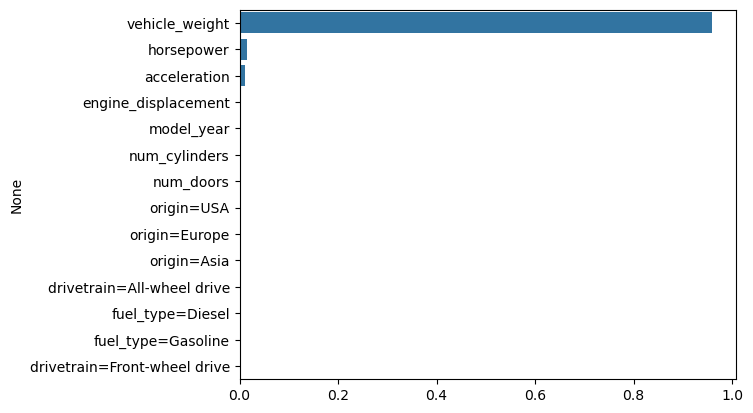

In [ ]:
sns.barplot(x=feature_importances.values, y=feature_importances.index)

`vehicle_weight` is the most important feature

## Q6. XGBoost regressor

In [45]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [46]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
rmse(y_val, y_pred)

0.45017755678087246

In [47]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
rmse(y_val, y_pred)

0.42622800553359225

The best RMSE score is achieved from `eta=0.1` with 0.426